## Compute lag features for gradient boosting model

In [536]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [464]:
colnames = ['id', 'ts', 'station_name', 'address', 'total_docks',
           'docks_in_service', 'available_docks', 'available_bikes',
           'percent_full', 'status', 'latitude', 'longitude', 'location', 'record']
docks_df = pd.read_csv('/Users/jordi/Downloads/chicago_docks.csv', names=colnames)

In [465]:
# drop unnecessary columns
docks_df = docks_df.drop(columns=['location', 'record'])

In [466]:
docks_df.head()

,id,ts,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,longitude
0,2,10/26/2018 11:55:13 AM,Buckingham Fountain,Buckingham Fountain,39,39,36,3,8,In Service,41.876470,-87.620340
1,3,10/26/2018 11:55:13 AM,Shedd Aquarium,Shedd Aquarium,55,54,50,4,7,In Service,41.867226,-87.615355
2,4,10/26/2018 11:55:13 AM,Burnham Harbor,Burnham Harbor,23,23,9,14,61,In Service,41.856268,-87.613348
3,5,10/26/2018 11:55:13 AM,State St & Harrison St,State St & Harrison St,23,22,20,2,9,In Service,41.874053,-87.627716
4,6,10/26/2018 11:55:13 AM,Dusable Harbor,Dusable Harbor,39,38,32,6,16,In Service,41.886976,-87.612813


In [467]:
docks_df.id.unique().shape

(615,)

In [468]:
stations_df = pd.read_csv('./datasets/chicago_stations.csv')

In [469]:
stations_df.head()

,Unnamed: 0,id,station_name,address,lat,lon
0,0,2,Buckingham Fountain,Buckingham Fountain,41.876470,-87.620340
1,1,3,Shedd Aquarium,Shedd Aquarium,41.867226,-87.615355
2,2,4,Burnham Harbor,Burnham Harbor,41.856268,-87.613348
3,3,5,State St & Harrison St,State St & Harrison St,41.874053,-87.627716
4,4,6,Dusable Harbor,Dusable Harbor,41.886976,-87.612813


In [470]:
stations_df.id.unique().shape

(615,)

In [471]:
station_ids = stations_df.id.unique()

## Preprocess at station level

In [722]:
station_id = station_ids[10]
df = docks_df[docks_df.id == station_id]
df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)

In [723]:
df.ts.min(), df.ts.max()

(Timestamp('2017-01-01 00:05:11'), Timestamp('2018-10-26 11:55:13'))

In [724]:
# round ts every 5 minutes (seconds are not aligned)
df.loc[:, 'ts'] = df.ts.dt.round('5min')
df.sort_values(by='ts', inplace=True)

In [725]:
# resample data, there are missing info gaps
df = df.set_index('ts').resample('10Min', how='last', base=5).bfill()

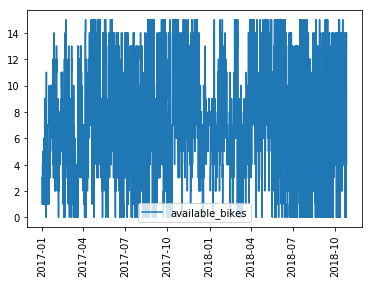

In [726]:
plt.plot(df.index, df.available_bikes, label='available_bikes')
plt.xticks(rotation=90)
plt.legend()

In [727]:
# every hour we have 6 rows, one every 10 minutes
entries_per_hour = 6

In [728]:
# month of year
df['month'] = df.index.month
# quarter of year
df['quarter'] = df.index.quarter
# day of month
df['day'] = df.index.day
# hour of day
df['hour'] = df.index.hour
# quarter of hour
df['quarter_hour'] = np.floor(df.index.minute / 15)
# day of week
df['dow'] = df.index.dayofweek
# week of year
df['week'] = df.index.weekofyear

In [729]:
ab_daily_mean = df.groupby('day')['available_bikes'].mean()
ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

In [730]:
for i, x in zip(ab_daily_mean.index, ab_daily_mean):
    df.loc[df.day == i, 'ab_daily_mean'] = x
    
for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
    df.loc[df.month == i, 'ab_monthly_mean'] = x
    
for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
    df.loc[df.week == i, 'ab_weekly_mean'] = x

In [731]:
last_1w_hourly_mean = df.shift(entries_per_hour*24*7 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_1w_daily_mean = df.shift(entries_per_hour*24*7 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()
last_2w_hourly_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_2w_daily_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()

In [732]:
df['last_1w_hourly_mean'] = last_1w_hourly_mean
df['last_1w_daily_mean'] = last_1w_daily_mean
df['last_2w_hourly_mean'] = last_2w_hourly_mean
df['last_2w_daily_mean'] = last_2w_daily_mean

In [733]:
# set status to unknown when status is not available
df.loc[pd.isna(df.status), 'status'] = 'Unknown'

In [734]:
df.columns

Index(['id', 'station_name', 'address', 'total_docks', 'docks_in_service',
       'available_docks', 'available_bikes', 'percent_full', 'status',
       'latitude', 'longitude', 'month', 'quarter', 'day', 'hour',
       'quarter_hour', 'dow', 'week', 'ab_daily_mean', 'ab_monthly_mean',
       'ab_weekly_mean', 'last_1w_hourly_mean', 'last_1w_daily_mean',
       'last_2w_hourly_mean', 'last_2w_daily_mean'],
      dtype='object')

### Set train/test splits

In [735]:
train_df = df.query('20170101 <= ts < 20180928')
# 2 weeks for validation
val_df = df.query('20180928 <= ts < 20181012')
# 2 weeks for test
test_df = df.query('ts >= 20181012')

In [736]:
train_df.shape, val_df.shape, test_df.shape

((91440, 25), (2016, 25), (2088, 25))

In [737]:
# overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
# this info is not available at test time!
idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]

In [738]:
# drop first 2 weeks in train, no info for last_1w/2w features
train_df = train_df.iloc[entries_per_hour*24*7*2:]

In [739]:
train_df.shape, val_df.shape, test_df.shape

((89424, 25), (2016, 25), (2088, 25))

In [740]:
train_df.index.min(), train_df.index.max(), val_df.index.min(), val_df.index.max(), test_df.index.min(), test_df.index.max()

(Timestamp('2017-01-15 00:05:00', freq='10T'),
 Timestamp('2018-09-27 23:55:00', freq='10T'),
 Timestamp('2018-09-28 00:05:00', freq='10T'),
 Timestamp('2018-10-11 23:55:00', freq='10T'),
 Timestamp('2018-10-12 00:05:00', freq='10T'),
 Timestamp('2018-10-26 11:55:00', freq='10T'))

In [755]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

xs_features = ['total_docks', 'docks_in_service', 'status', 'ab_daily_mean', 'ab_monthly_mean', 'ab_weekly_mean',
              'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
              'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
target = ['available_bikes']

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])
val_df['status'] = le.transform(val_df['status'])
test_df['status'] = le.transform(test_df['status'])

train_data = lgb.Dataset(train_df[xs_features], label=train_df[target],
                        feature_name=xs_features, categorical_feature=['status'])
val_data = lgb.Dataset(val_df[xs_features], label=val_df[target],
                      feature_name=xs_features, categorical_feature=['status'], reference=train_data)
test_data = lgb.Dataset(test_df[xs_features], label=test_df[target],
                       feature_name=xs_features, categorical_feature=['status'])

In [756]:
test_df.head()

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,quarter_hour,dow,week,ab_daily_mean,ab_monthly_mean,ab_weekly_mean,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2018-10-12 00:05:00,14.0,Morgan St & 18th St,Morgan St & 18th St,15.0,15.0,8.0,7.0,47.0,0,41.858086,...,0.0,4,41,7.597222,8.411136,8.169147,9.166667,9.756944,13.0,8.381944
2018-10-12 00:15:00,14.0,Morgan St & 18th St,Morgan St & 18th St,15.0,15.0,8.0,7.0,47.0,0,41.858086,...,1.0,4,41,7.597222,8.411136,8.169147,9.000000,9.777778,13.0,8.340278
2018-10-12 00:25:00,14.0,Morgan St & 18th St,Morgan St & 18th St,15.0,15.0,8.0,7.0,47.0,0,41.858086,...,1.0,4,41,7.597222,8.411136,8.169147,9.000000,9.805556,13.0,8.298611
2018-10-12 00:35:00,14.0,Morgan St & 18th St,Morgan St & 18th St,15.0,15.0,8.0,7.0,47.0,0,41.858086,...,2.0,4,41,7.597222,8.411136,8.169147,9.000000,9.833333,13.0,8.256944
2018-10-12 00:45:00,14.0,Morgan St & 18th St,Morgan St & 18th St,15.0,15.0,8.0,7.0,47.0,0,41.858086,...,3.0,4,41,7.597222,8.411136,8.169147,9.000000,9.861111,13.0,8.215278


In [757]:
params = {
    'objective': 'regression_l2',
    'num_threds': 4,
    'max_depth': 5,
    'num_boost_rounds': 100
}
bst = lgb.train(params, train_data, valid_sets=[val_data, test_data], early_stopping_rounds=10)

[1]	valid_0's l2: 19.4132	valid_1's l2: 13.3201
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 18.9564	valid_1's l2: 12.6215
[3]	valid_0's l2: 18.5981	valid_1's l2: 12.0303
[4]	valid_0's l2: 18.25	valid_1's l2: 11.469
[5]	valid_0's l2: 17.5966	valid_1's l2: 11.1308
[6]	valid_0's l2: 17.3732	valid_1's l2: 11.0749
[7]	valid_0's l2: 17.0776	valid_1's l2: 10.9168
[8]	valid_0's l2: 16.9402	valid_1's l2: 10.9733
[9]	valid_0's l2: 16.783	valid_1's l2: 10.9497
[10]	valid_0's l2: 16.6189	valid_1's l2: 10.8788
[11]	valid_0's l2: 16.5461	valid_1's l2: 11.0342
[12]	valid_0's l2: 16.4896	valid_1's l2: 10.9323
[13]	valid_0's l2: 15.991	valid_1's l2: 11.0273
[14]	valid_0's l2: 15.9536	valid_1's l2: 10.9391
[15]	valid_0's l2: 15.7598	valid_1's l2: 10.9244
[16]	valid_0's l2: 15.5742	valid_1's l2: 11.1814
[17]	valid_0's l2: 15.5967	valid_1's l2: 11.5398
[18]	valid_0's l2: 15.4632	valid_1's l2: 11.6252
[19]	valid_0's l2: 15.3103	valid_1's l2: 11.7001
[20]	valid_0's l2: 15

In [758]:
y_true = test_df['available_bikes']
y_hat = bst.predict(test_df[xs_features], num_iteration=bst.best_iteration)

In [759]:
np.sqrt(np.mean((y_true - y_hat)**2))

3.2983008344526663

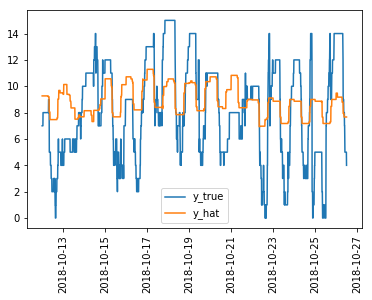

In [760]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()

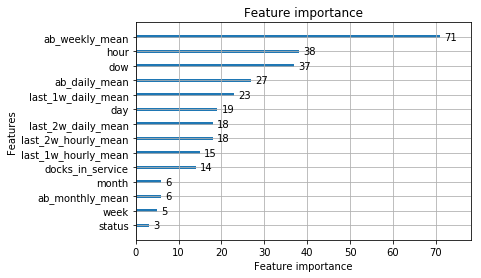

In [761]:
# plot feature importance
lgb.plot_importance(bst)